import libraries

In [28]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from networkx.generators.intersection import k_random_intersection_graph

from support.hyperphoto import HyperPhoto

parameters

In [29]:
# פרמטרים מה-header
width = 800  # עמודות (x)
height = 280  # שורות (y)
bands = 126  # ערוצים (z)
source_path = r'C:\Users\ronsh\Desktop\big_data_for_projects\self_test_rad.img'
dtype = np.int16  # data type = 2
# פרמטרים לניתוח גרפים
range_ = (0, 1000)
bins = 500



import hyper photo

In [30]:
shape = (height,width, bands)

hyperPhoto = HyperPhoto(source_path, shape, np.int16)


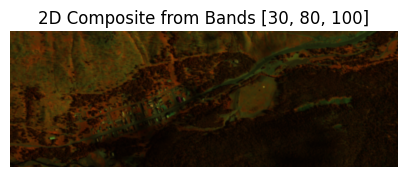

In [31]:
hyperPhoto.show([30,80,100])

k_means

In [32]:
def kmeans(X, k, max_iters=10000):
    # X shape: (n_samples, n_features)
    X_shape = X.shape
    X = X.reshape(-1, X.size(-1))
    # 1. Choose random initial centroids
    idx = torch.randperm(X.size(0))[:k]
    centroids = X[idx]

    for _ in range(max_iters):
        # 2. Compute distances (PyTorch built-in)
        distances = torch.cdist(X, centroids)

        # 3. Assign each sample to closest centroid
        labels = torch.argmin(distances, dim=1)

        # 4. Recompute centroids
        new_centroids = torch.stack([
            X[labels == c].mean(dim=0) if (labels == c).sum() > 0 else centroids[c]
            for c in range(k)
        ])

        # 5. Stop if no significant change
        if torch.allclose(centroids, new_centroids, atol=1e-4):
            break

        centroids = new_centroids

    return centroids, labels

In [33]:
def show_k(labels,shape):
    import matplotlib.pyplot as plt
    import numpy as np

    label_map = labels.reshape(shape)


    def colorize_labels(label_map):
        K = int(label_map.max().item() + 1)
        colors = np.random.rand(K, 3)  # צבע רנדומלי לכל אובייקט
        rgb = colors[label_map.cpu().numpy()]
        return rgb


    rgb_map = colorize_labels(label_map)

    plt.imshow(rgb_map)
    plt.title("K-means segmentation")
    plt.axis("off")
    plt.show()

In [34]:
def plot_cluster_means(X, labels):
    clusters = np.unique(labels)
    means = []

    for c in clusters:
        means.append(X[labels == c].mean(axis=0))  # ממוצע לכל ממד

    means = np.array(means)

    plt.figure(figsize=(10, 6))

    for i, c in enumerate(clusters):
        plt.plot(means[i], marker='o', label=f"Cluster {c}")

    plt.title("Cluster Mean Profile")
    plt.xlabel("Feature Index")
    plt.ylabel("Mean Value")
    plt.legend()
    plt.grid(True)
    plt.show()

initial statistics

In [35]:
# print(labels)
# labels = (labels==3).int()
# print(labels)

In [36]:
hyperPhoto.initial_statistics()
_=hyperPhoto.compute_rx()


init error
torch.Size([280, 800, 126])
init cov
torch.Size([126, 126])


split functions

In [37]:
data = hyperPhoto.data
domain = []
for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        domain.append([x, y])
domain = torch.tensor(domain, dtype=torch.int16).reshape(list(data.shape[:2]) + [2])


In [38]:
class Split_function(torch.nn.Module):
    def __init__(self,function):
        self.function = function
        super(Split_function, self).__init__()

    def forward(self, x):
        return self.function(x)


In [39]:
forplot = []

In [40]:
from support.split_lub import SplitBub


def comper(hyperPhoto,f1,f2,f1Name,f2Name,domain ,sizes,bins,range_,size_t):
    bins_ = 0
    solution_1 = {}
    rx_1 = {}
    plt.figure(figsize=(10, 6))
    for size in sizes:
        sample = f1(domain,hyperPhoto ,size)
        rx = hyperPhoto.compute_sub_rx(sample)
        counts, bins__, patches = plt.hist(
            rx.view(-1).numpy(),  # שימוש בנתוני NT
            bins=bins,
            range=range_,
            density=True,
            histtype='step',
            label=f'{size}',  # הוספת התווית NT למקרא
        )
        rx_1[size] = rx
        solution_1 [size] =counts
        bins_ = bins__

    # הגדרות הגרף
    plt.legend()
    plt.legend(title="sample size")
    plt.xlabel("rx")
    plt.ylabel("density")  # שינינו ל-Count כי הסרנו density=True
    plt.title(f"{f1Name} rx - density")
    plt.show(f'{f1Name}')

    solution_2 = {}
    rx_2 = {}
    plt.figure(figsize=(10, 6))
    for size in sizes:
        sample = f2(domain,hyperPhoto, size)
        rx = hyperPhoto.compute_sub_rx(sample)
        counts, bins__, patches = plt.hist(
            rx.view(-1).numpy(),  # שימוש בנתוני NT
            bins=bins,
            range=range_,
            density=True,
            histtype='step',
            label=f'{size}',  # הוספת התווית NT למקרא
        )
        rx_2[size] = counts
        solution_2 [size] = counts

    # הגדרות הגרף
    plt.legend()
    plt.legend(title="sample size")
    plt.xlabel("rx")
    plt.ylabel("density")  # שינינו ל-Count כי הסרנו density=True
    plt.title(f"{f2Name} rx - density")
    plt.show(f'{f2Name}')


    for size in sizes[:-1]:
        plt.plot(
            np.cumsum(solution_1.get(size)),
            np.cumsum(solution_2.get(size)), label=f"{size}")
    plt.xlabel(f"{f1Name}")
    plt.ylabel(f"{f2Name}")
    plt.title("scatter plot")
    plt.legend()
    plt.show()
    print(np.cumsum(solution_1.get(0)))

    target_path = "./data/t.pt"
    p = 0.03

    splitBub = SplitBub(source_path,shape,target_path,p)
    splitBub.compute_p(f2(domain,hyperPhoto, 873))
    forplot.append((f2Name,splitBub.show_analize(range_ = (-500,500))))


random

In [41]:
def random_split(domain, rx,smple_size):
    place = torch.randint(0, domain.size(0) * domain.size(1), (smple_size,))
    return domain.view(-1, 2)[place]

In [42]:
def k_largest(domain, hyperphoto, k):
    _, idx = torch.sort(hyperphoto.rx.view(-1))

    return domain.view(-1, 2)[idx[-k:]]


In [43]:
def k_smolest(domain, hyperphoto, k):
    _, idx = torch.sort(hyperphoto.rx.view(-1))

    return domain.view(-1, 2)[idx[:k]]

In [44]:
def k_top(domain, hyperphoto, k):
    return domain.view(-1, 2)[range(k)]


In [45]:
def k_mean(domain, hyperphoto, k):
    centroids, labels = kmeans(hyperPhoto.data.reshape(-1, hyperphoto.data.size(-1)), 5, 100000000)
    centroids_n = centroids.abs() / centroids.norm(dim=1, keepdim=True)
    centroids_n = centroids_n - centroids_n.mean(dim=0, keepdim=True)
    centroids_n = (centroids_n * centroids_n).sum(dim=1)
    t_index = torch.argmax(centroids_n)
    t = centroids[t_index]
    return domain.view(-1, 2)[labels != t_index]


In [46]:
print(domain.shape)
sizes = [224000,112000,56000,28000,14000,7000,3500]
bins = 400

torch.Size([280, 800, 2])


init error
torch.Size([280, 800, 126])
init cov
torch.Size([126, 126])


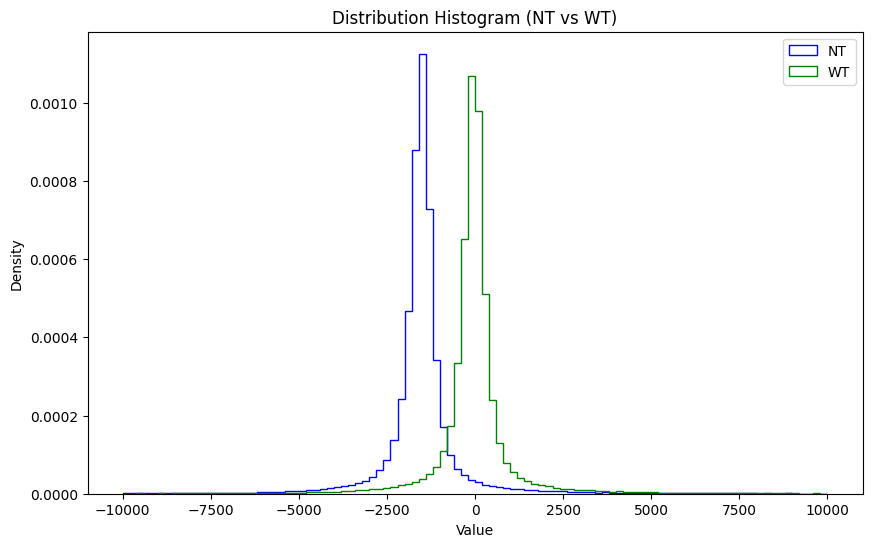

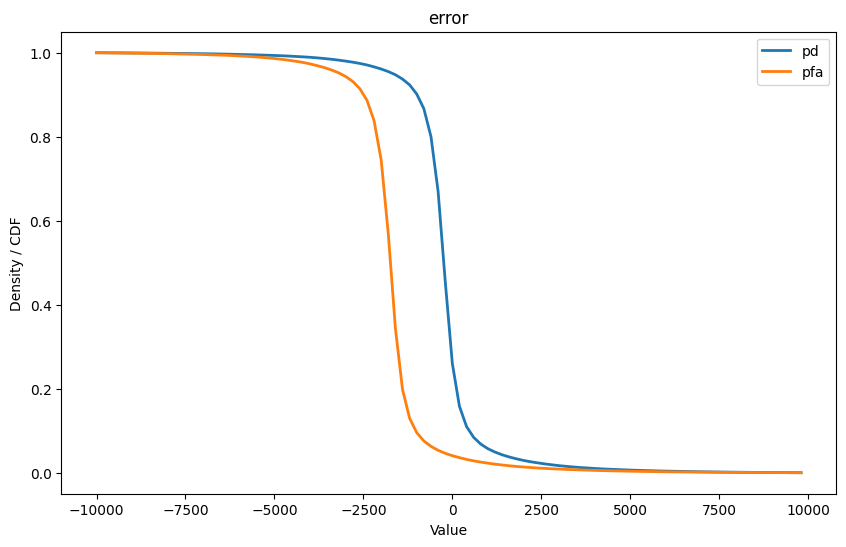

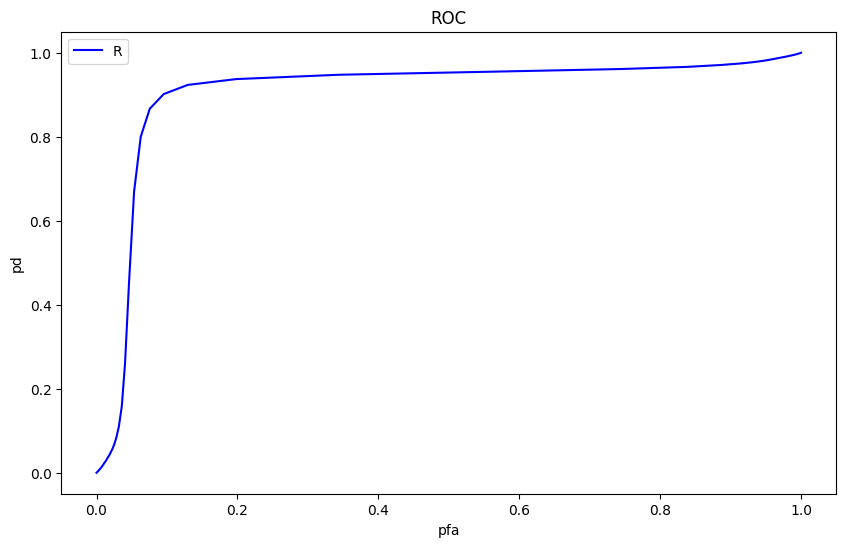

In [47]:
target_path = "./data/t.pt"
p = 0.03

splitBub = SplitBub(source_path,shape,target_path,p)
splitBub.compute_p(k_smolest(domain,hyperPhoto, 3500))
forplot.append(("k-min",splitBub.show_analize(range_ = (-10000,10000))))

init error
torch.Size([280, 800, 126])
init cov
torch.Size([126, 126])


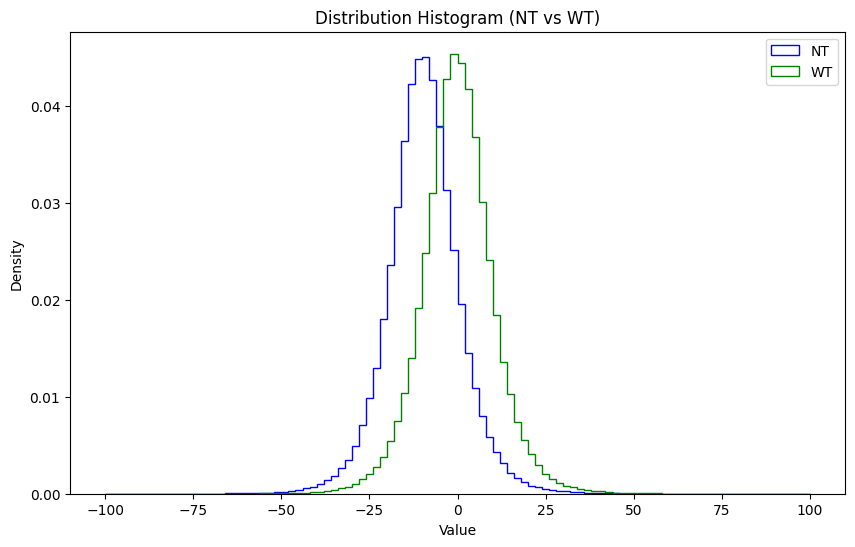

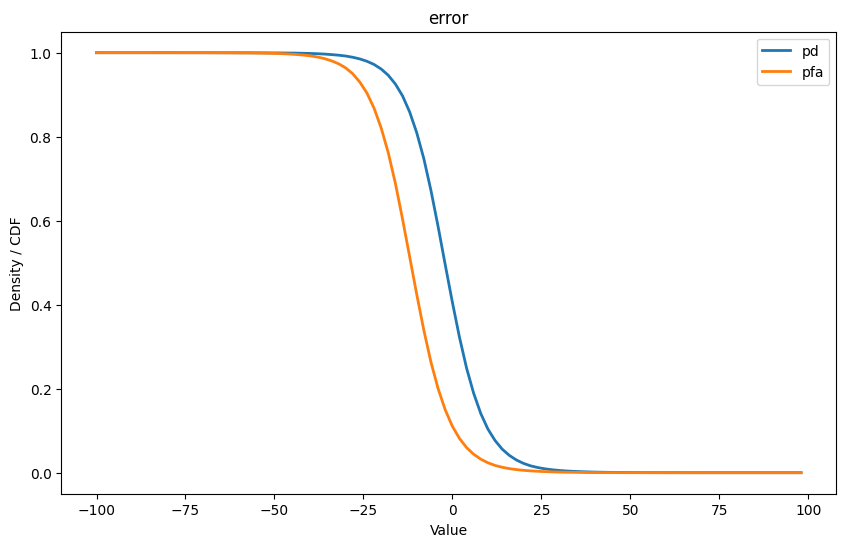

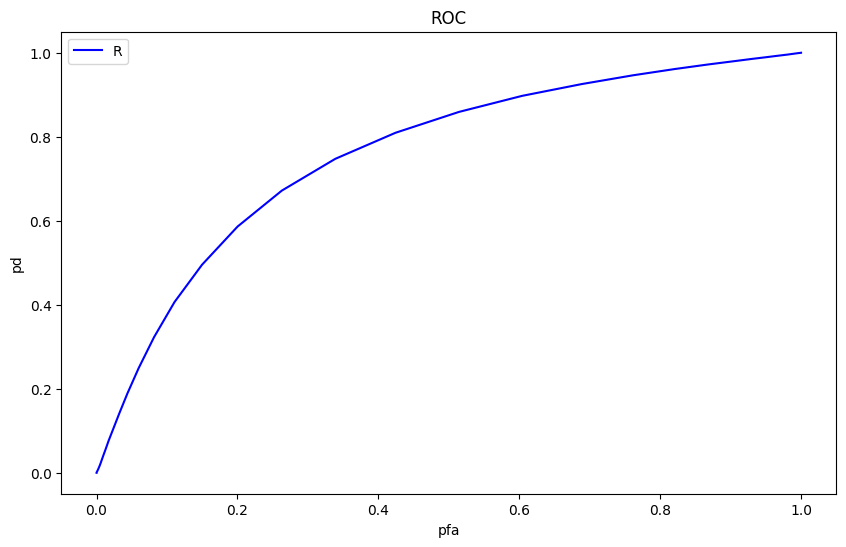

In [48]:
target_path = "./data/t.pt"
p = 0.03

splitBub = SplitBub(source_path,shape,target_path,p)
splitBub.compute_p(k_largest(domain,hyperPhoto, 873))
forplot.append(("k-max",splitBub.show_analize(range_ = (-100,100))))

init error
torch.Size([280, 800, 126])
init cov
torch.Size([126, 126])


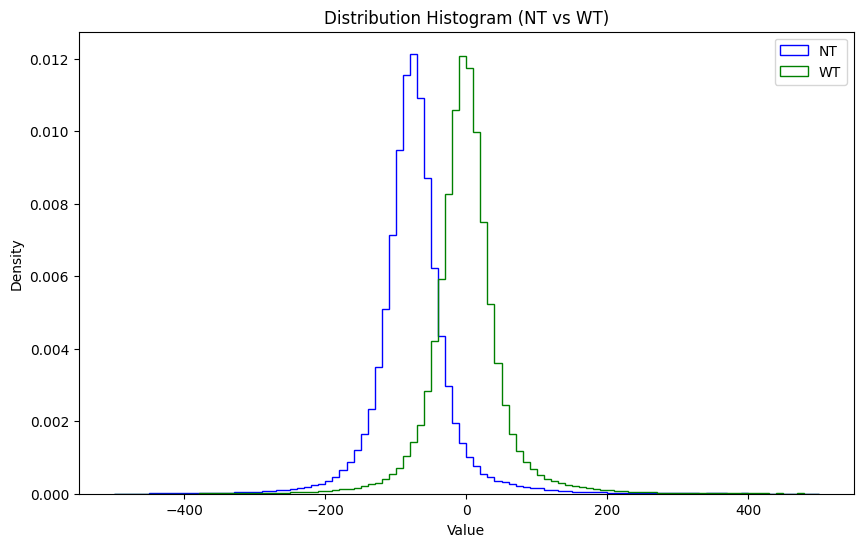

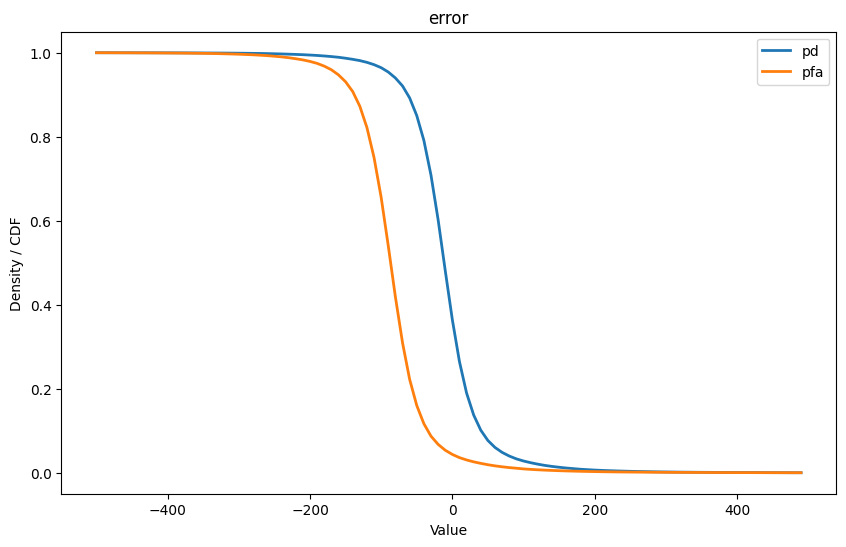

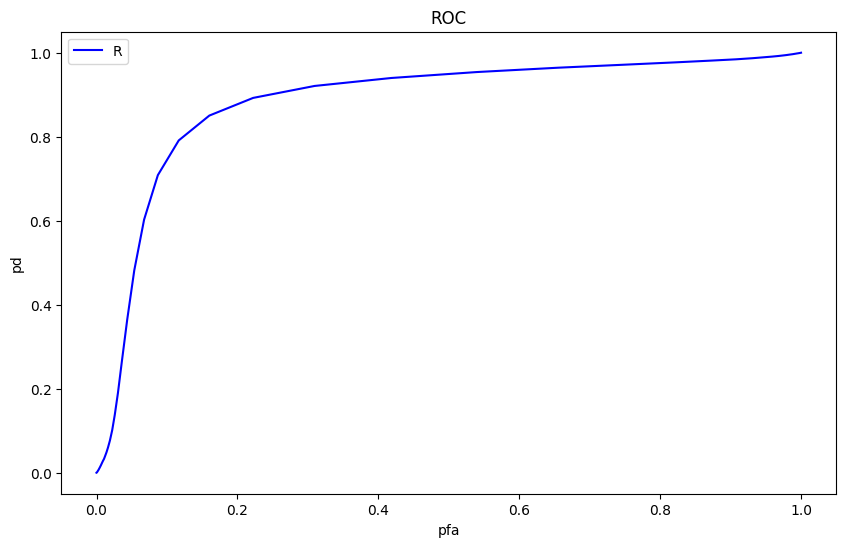

In [49]:
target_path = "./data/t.pt"
p = 0.03

splitBub = SplitBub(source_path,shape,target_path,p)
splitBub.compute_p(k_mean(domain,hyperPhoto, 873))
forplot.append(("k-mean",splitBub.show_analize(range_ = (-500,500))))


init error
torch.Size([280, 800, 126])
init cov
torch.Size([126, 126])


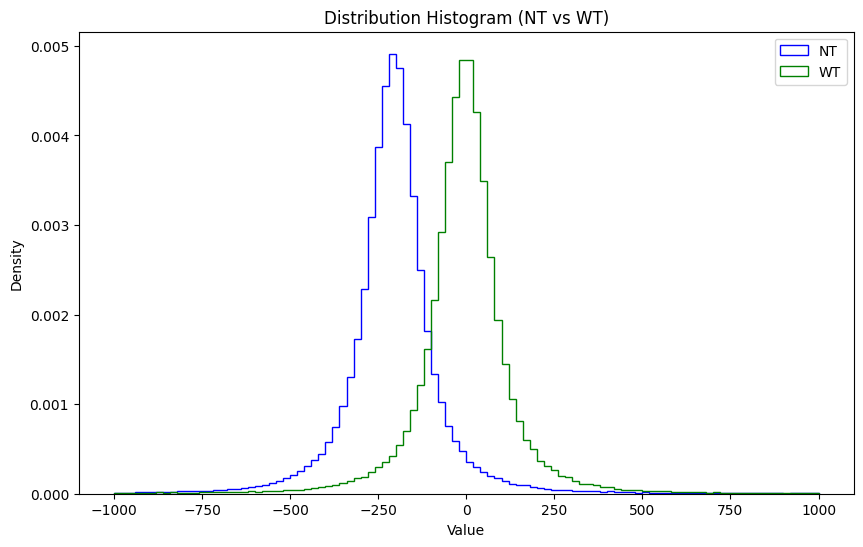

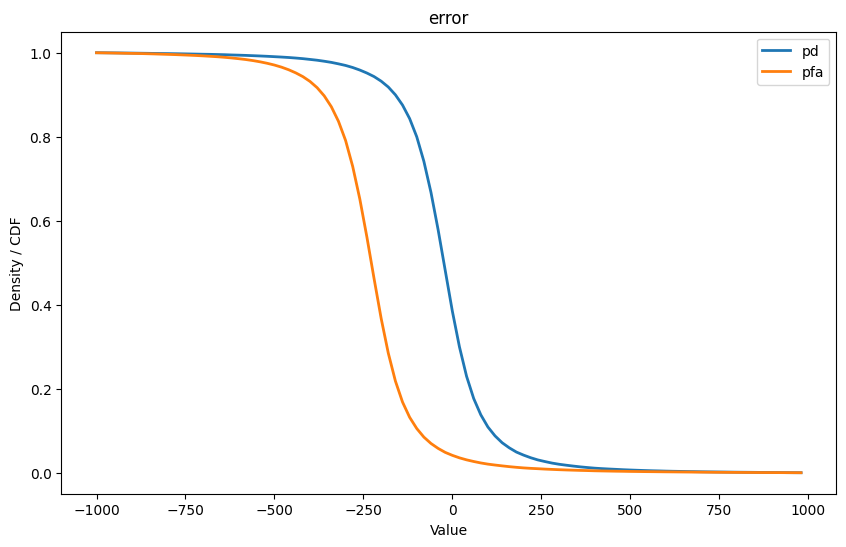

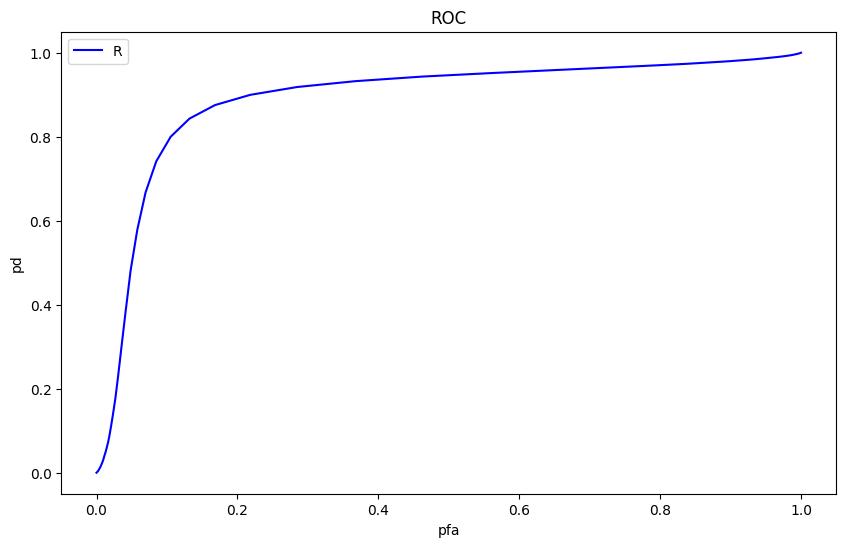

In [50]:
splitBub = SplitBub(source_path,shape,target_path,p)
splitBub.compute_p(k_top(domain,hyperPhoto, sizes[-1]))
forplot.append(("k-top",splitBub.show_analize(range_ = (-1000,1000))))

init error
torch.Size([280, 800, 126])
init cov
torch.Size([126, 126])


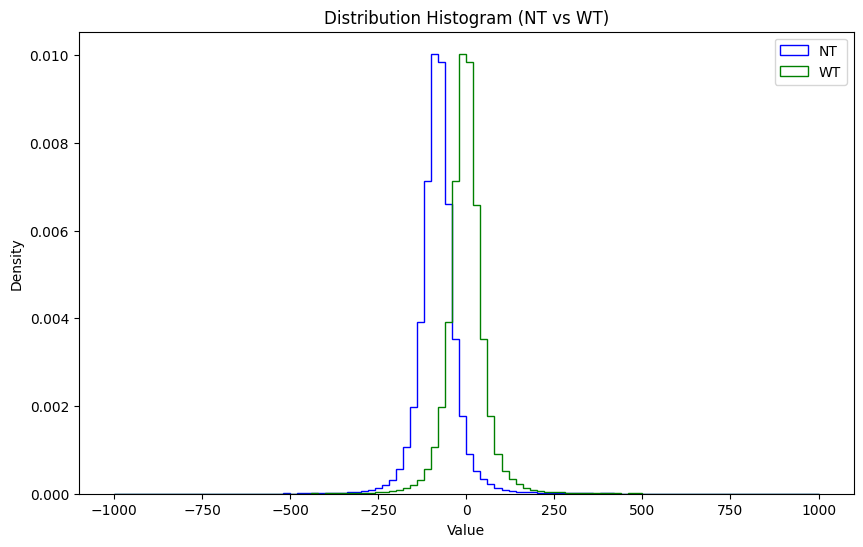

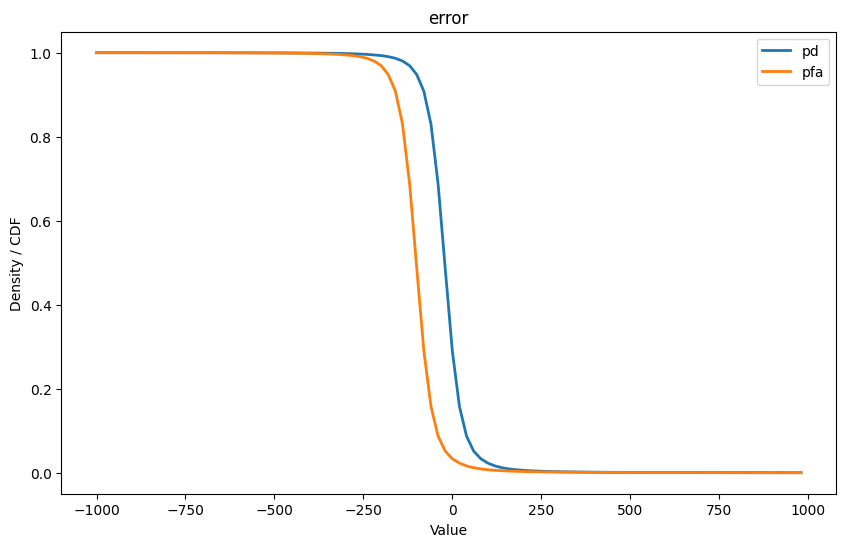

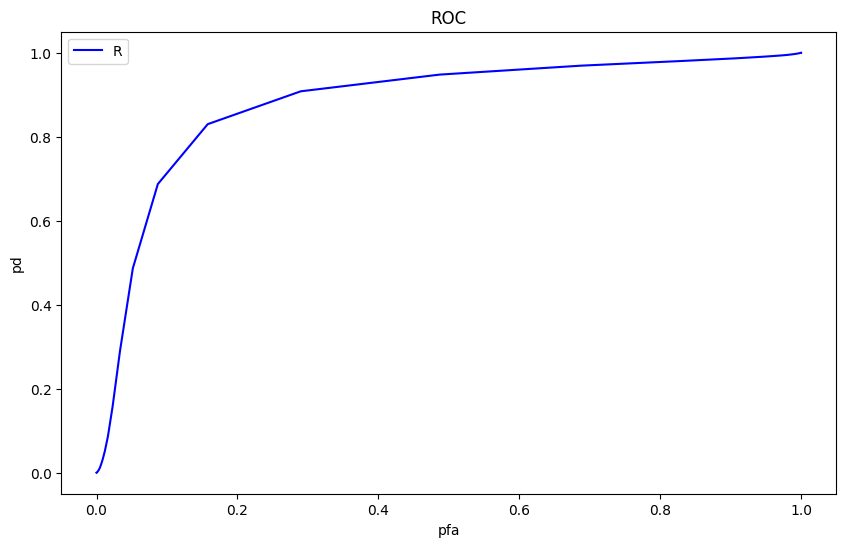

In [51]:
splitBub = SplitBub(source_path,shape,target_path,p)
splitBub.compute_p(random_split(domain,hyperPhoto, 3500))
forplot.append(("random - 3500",splitBub.show_analize(range_ = (-1000,1000))))

init error
torch.Size([280, 800, 126])
init cov
torch.Size([126, 126])


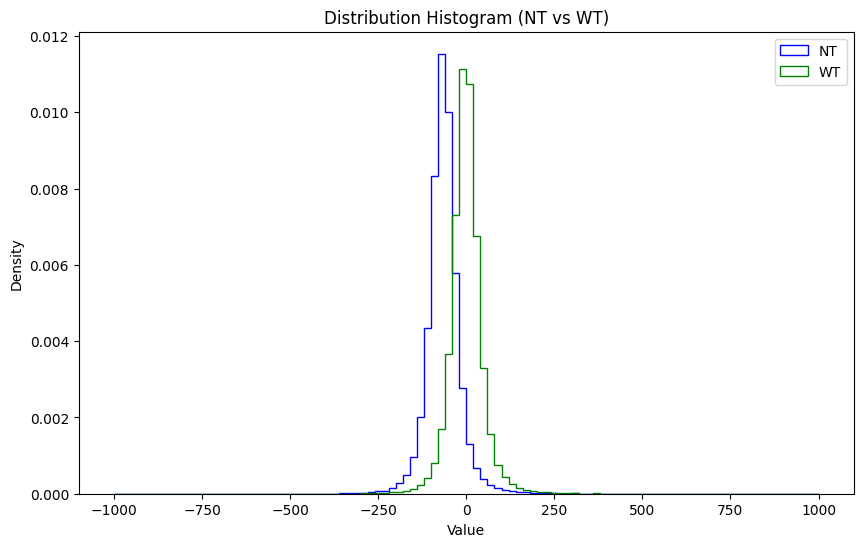

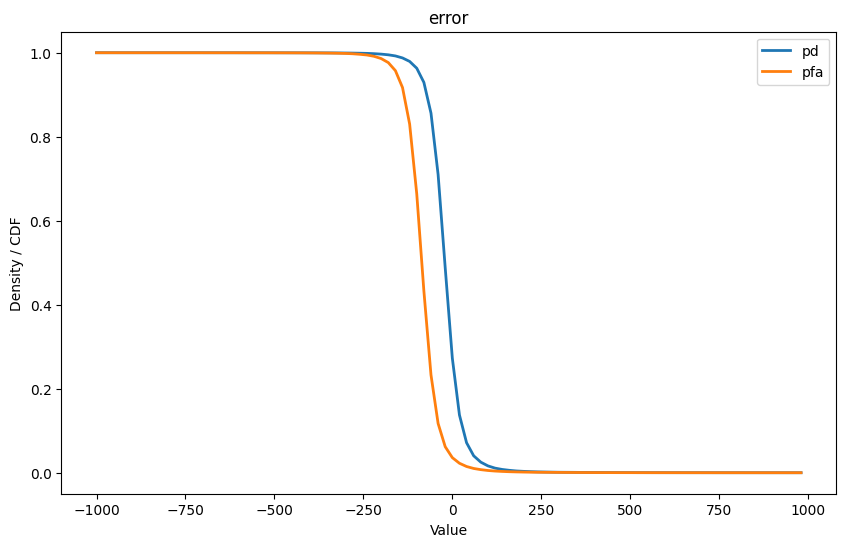

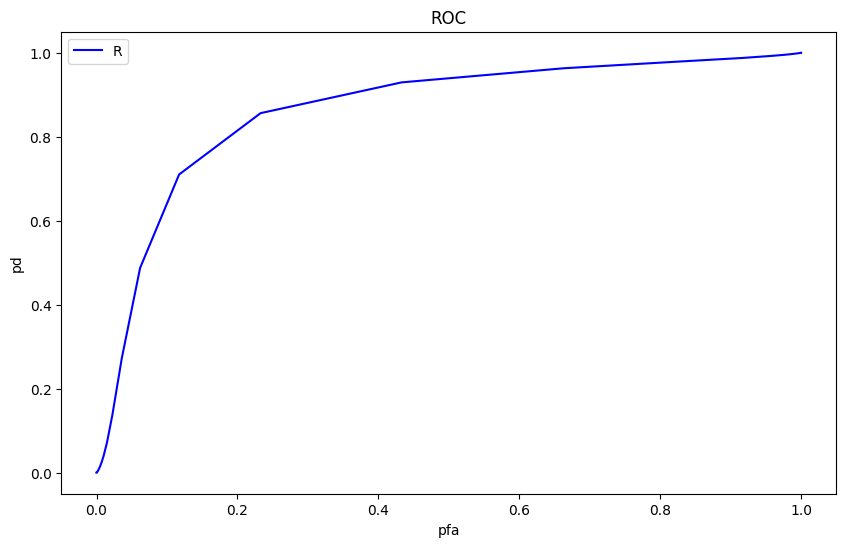

In [52]:
splitBub = SplitBub(source_path,shape,target_path,p)
splitBub.compute_p(random_split(domain,hyperPhoto, sizes[-1]))
forplot.append(("full",splitBub.show_analize(range_ = (-1000,1000))))

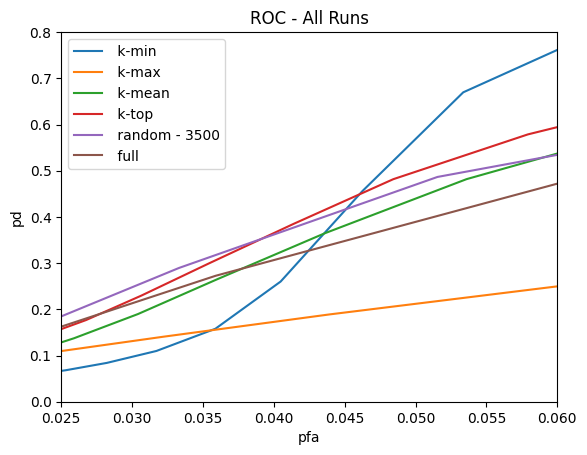

In [53]:
plt.figure()

for name,(l,r) in forplot:
    plt.plot(l, r, label=f" {name}")

plt.xlabel("pfa")
plt.ylabel("pd")
plt.title("ROC - All Runs")
plt.legend()
plt.xlim(0.025, 0.06)
plt.ylim(0, 0.8)
plt.show()


In [54]:
n_ = 0
for n in range(len(pfa)):
    if pfa[n] < 0.1:
        n_ = n
        break

plt.plot(pfa[n_:], pd[n_:], label="R", color='blue')
plt.plot(np.arange(0, 0.1, 0.001), np.arange(0, 0.1, 0.001), label="th", color='blue', linestyle='--')

plt.xlabel("pfa")
plt.ylabel("pd")
plt.title("ROC ")
plt.legend()
plt.show()


NameError: name 'pfa' is not defined

In [ ]:



# x and y are already numpy arrays of shape (1000,)
# but ensure they are 1D
pfa_ = pfa.flatten()
pd_n = pd.flatten() - pfa_

# --- Sort by x ---
sort_idx = np.argsort(pfa_)
x_sorted = pfa_[sort_idx]
y_sorted = pd_n[sort_idx]

# --- Cumulative integral using trapezoidal rule ---
a_th = np.zeros_like(y_sorted)
a_th[1:] = np.cumsum((y_sorted[:-1] + y_sorted[1:]) * np.diff(x_sorted)) / (
        2 * (x_sorted[1:] - x_sorted[1:] * x_sorted[1:] / 2))

# --- Plot both graphs ---
plt.figure(figsize=(12, 5))

# Integral curve
plt.subplot(1, 2, 2)
plt.plot(x_sorted, a_th, linewidth=2)
plt.title("Integral F(x) = ∫y dx")
plt.xlabel("x")
plt.ylabel("Integral")

plt.tight_layout()
plt.show()



In [ ]:
def sROC(x):
    for i, n in enumerate(x_sorted):
        if n > x:
            return (a_th[i].tolist())
    return (1.0)


In [ ]:
type(sROC(0.1))

In [ ]:
print(f'0.001-> {sROC(0.001):.4f}')
print(f'0.01-> {sROC(0.01):.4f}')
print(f'0.1-> {sROC(0.1):.4f}')
